In [1]:
#!pip install tensorflow==1.14.0

In [2]:
#!pip install keras==2.2.5

In [3]:
import os
os.environ["PYTHONHASHSEED"] = "13"
os.environ["CUDA_VISIBLE_DEVICES"] = "0:1"

import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(13)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(13)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(13)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [4]:
import gc
import warnings

#import lightgbm as lgb
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm

import keras
from keras.models import Sequential
from keras.layers import BatchNormalization, Dense, Dropout

path_data = "../input/ashrae-energy-prediction/"
path_train = path_data + "train.csv"
path_test = path_data + "test.csv"
path_building = path_data + "building_metadata.csv"
path_weather_train = path_data + "weather_train.csv"
path_weather_test = path_data + "weather_test.csv"

myfavouritenumber = 13
seed = myfavouritenumber

warnings.filterwarnings("ignore")

In [5]:
site_id = 7

In [6]:
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

building = pd.read_csv(path_building)

weather_train = pd.read_csv(path_weather_train)
weather_test = pd.read_csv(path_weather_test)

weather_train.drop(["sea_level_pressure", "wind_direction", "wind_speed"], axis=1, inplace=True)
weather_test.drop(["sea_level_pressure", "wind_direction", "wind_speed"], axis=1, inplace=True)

weather_train = weather_train.groupby("site_id").apply(lambda group: group.interpolate(limit_direction="both"))
weather_test = weather_test.groupby("site_id").apply(lambda group: group.interpolate(limit_direction="both"))

df_train = df_train.merge(building, on="building_id")
df_test = df_test.merge(building, on="building_id")

df_train = df_train[df_train.site_id == site_id]
df_test = df_test[df_test.site_id == site_id]

df_train = df_train[~((df_train.building_id == 789) & (df_train.meter_reading == 0))]
df_train = df_train[~((df_train.building_id == 790) & (df_train.meter_reading == 0))]
df_train = df_train[~((df_train.building_id == 791) & (df_train.meter_reading == 0))]
df_train = df_train[~((df_train.building_id == 792) & (df_train.meter_reading == 0))]
df_train = df_train[~((df_train.building_id == 795) & (df_train.meter == 0) & (df_train.meter_reading == 0))]
df_train = df_train[~((df_train.building_id == 798) & (df_train.meter_reading == 0))]
df_train = df_train[~((df_train.building_id == 799) & (df_train.meter == 0) & (df_train.meter_reading == 0))]
df_train = df_train[~((df_train.building_id == 801) & (df_train.meter_reading == 0))]
df_train = df_train[~((df_train.building_id == 802) & (df_train.meter_reading == 0))]

df_train = df_train[df_train.meter == 0]

df_train = df_train.merge(weather_train, on=["site_id", "timestamp"], how="left")
df_test = df_test.merge(weather_test, on=["site_id", "timestamp"], how="left")

df_train.timestamp = pd.to_datetime(df_train.timestamp, format='%Y-%m-%d %H:%M:%S')
df_test.timestamp = pd.to_datetime(df_test.timestamp, format='%Y-%m-%d %H:%M:%S')

df_train.building_id = df_train.building_id.astype("str")
df_test.building_id = df_test.building_id.astype("str")

df_train["log_meter_reading"] = np.log1p(df_train.meter_reading)

del building
gc.collect()

148

In [7]:
df_train["hour"] = df_train.timestamp.dt.hour.astype("str")
df_test["hour"] = df_test.timestamp.dt.hour.astype("str")

df_train["weekday"] = df_train.timestamp.dt.weekday.astype("str")
df_test["weekday"] = df_test.timestamp.dt.weekday.astype("str")

df_train["month"] = df_train.timestamp.dt.month.astype("str")
df_test["month"] = df_test.timestamp.dt.month.astype("str")

In [8]:
features = [
    "building_id",
    "square_feet",
    "year_built",
    "floor_count",
    "primary_use",
    "air_temperature",
    "cloud_coverage",
    "dew_temperature",
    "precip_depth_1_hr",
    "hour",
    "weekday",
    "month"
]

In [9]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [10]:
cv = 4
folds = KFold(n_splits = cv, shuffle = False, random_state = seed)

df_cv = []
df_preds = []

Building Model for site_id 7 and meter 0
Preparing Site: 7 , meter: 0 , Fold: 1



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 70880 samples, validate on 23627 samples
Epoch 1/31




 - 23s - loss: 6.9734 - val_loss: 6.6634
Epoch 2/31
 - 1s - loss: 6.4963 - val_loss: 6.0353
Epoch 3/31
 - 1s - loss: 5.7309 - val_loss: 5.0062
Epoch 4/31
 - 1s - loss: 4.6761 - val_loss: 3.6938
Epoch 5/31
 - 1s - loss: 3.5003 - val_loss: 2.2647
Epoch 6/31
 - 1s - loss: 2.6308 - val_loss: 1.1797
Epoch 7/31
 - 1s - loss: 2.2618 - val_loss: 0.6975
Epoch 8/31
 - 1s - loss: 2.1740 - val_loss: 0.6020
Epoch 9/31
 - 1s - loss: 2.1541 - val_loss: 0.5821
Epoch 10/31
 - 1s - loss: 2.1426 - val_loss: 0.5818
Epoch 11/31
 - 1s - loss: 2.1314 - val_loss: 0.5781
Epoch 12/31
 - 1s - loss: 2.1218 - val_loss: 0.5804
Epoch 13/31
 - 1s - loss: 2.1146 - 

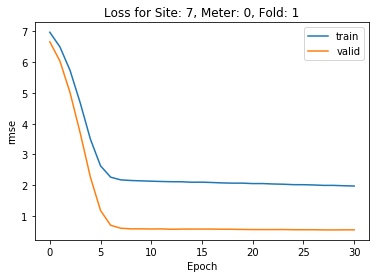

CPU times: user 6.37 s, sys: 302 ms, total: 6.67 s
Wall time: 5.21 s
Preparing Site: 7 , meter: 0 , Fold: 2
Train on 70880 samples, validate on 23627 samples
Epoch 1/31
 - 2s - loss: 6.9010 - val_loss: 6.8439
Epoch 2/31
 - 1s - loss: 6.2866 - val_loss: 6.0791
Epoch 3/31
 - 1s - loss: 5.4432 - val_loss: 4.9760
Epoch 4/31
 - 1s - loss: 4.3444 - val_loss: 3.5495
Epoch 5/31
 - 1s - loss: 3.2053 - val_loss: 2.2096
Epoch 6/31
 - 1s - loss: 2.4702 - val_loss: 1.2662
Epoch 7/31
 - 1s - loss: 2.1919 - val_loss: 0.9947
Epoch 8/31
 - 1s - loss: 2.1439 - val_loss: 0.9383
Epoch 9/31
 - 1s - loss: 2.1294 - val_loss: 0.9227
Epoch 10/31
 - 1s - loss: 2.1183 - val_loss: 0.9177
Epoch 11/31
 - 1s - loss: 2.1106 - val_loss: 0.9105
Epoch 12/31
 - 1s - loss: 2.0995 - val_loss: 0.9029
Epoch 13/31
 - 1s - loss: 2.0919 - val_loss: 0.8927
Epoch 14/31
 - 1s - loss: 2.0793 - val_loss: 0.8856
Epoch 15/31
 - 1s - loss: 2.0762 - val_loss: 0.8791
Epoch 16/31
 - 1s - loss: 2.0721 - val_loss: 0.8724
Epoch 17/31
 - 1s -

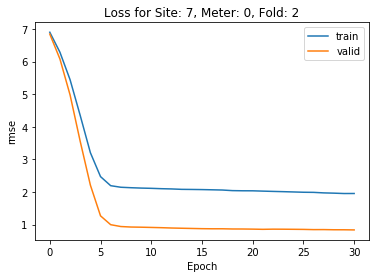

CPU times: user 6.49 s, sys: 367 ms, total: 6.86 s
Wall time: 5.39 s
Preparing Site: 7 , meter: 0 , Fold: 3
Train on 70880 samples, validate on 23627 samples
Epoch 1/31
 - 2s - loss: 7.0297 - val_loss: 6.3295
Epoch 2/31
 - 1s - loss: 6.4146 - val_loss: 5.6688
Epoch 3/31
 - 1s - loss: 5.6075 - val_loss: 4.6421
Epoch 4/31
 - 1s - loss: 4.5257 - val_loss: 3.3063
Epoch 5/31
 - 1s - loss: 3.3160 - val_loss: 1.9700
Epoch 6/31
 - 1s - loss: 2.4162 - val_loss: 1.4187
Epoch 7/31
 - 1s - loss: 2.1057 - val_loss: 1.2508
Epoch 8/31
 - 1s - loss: 2.0696 - val_loss: 1.2173
Epoch 9/31
 - 1s - loss: 2.0540 - val_loss: 1.2085
Epoch 10/31
 - 1s - loss: 2.0519 - val_loss: 1.2049
Epoch 11/31
 - 1s - loss: 2.0379 - val_loss: 1.2042
Epoch 12/31
 - 1s - loss: 2.0314 - val_loss: 1.1939
Epoch 13/31
 - 1s - loss: 2.0143 - val_loss: 1.1799
Epoch 14/31
 - 1s - loss: 2.0062 - val_loss: 1.1660
Epoch 15/31
 - 1s - loss: 2.0094 - val_loss: 1.1381
Epoch 16/31
 - 1s - loss: 1.9917 - val_loss: 1.1181
Epoch 17/31
 - 1s -

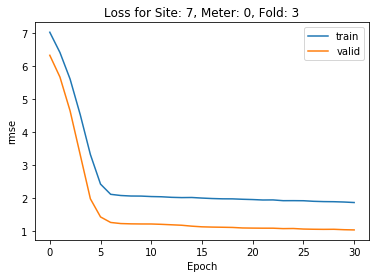

CPU times: user 5.84 s, sys: 322 ms, total: 6.16 s
Wall time: 4.75 s
Preparing Site: 7 , meter: 0 , Fold: 4
Train on 70881 samples, validate on 23626 samples
Epoch 1/31
 - 2s - loss: 7.0049 - val_loss: 6.5712
Epoch 2/31
 - 1s - loss: 6.3765 - val_loss: 5.8711
Epoch 3/31
 - 1s - loss: 5.3551 - val_loss: 4.8627
Epoch 4/31
 - 1s - loss: 4.0145 - val_loss: 3.6157
Epoch 5/31
 - 1s - loss: 2.6893 - val_loss: 2.5833
Epoch 6/31
 - 1s - loss: 2.0156 - val_loss: 2.1842
Epoch 7/31
 - 1s - loss: 1.8668 - val_loss: 2.0856
Epoch 8/31
 - 1s - loss: 1.8433 - val_loss: 2.0615
Epoch 9/31
 - 1s - loss: 1.8294 - val_loss: 2.0615
Epoch 10/31
 - 1s - loss: 1.8351 - val_loss: 2.0653
Epoch 11/31
 - 1s - loss: 1.8139 - val_loss: 2.0637
Epoch 12/31
 - 1s - loss: 1.7967 - val_loss: 2.0576
Epoch 13/31
 - 1s - loss: 1.7883 - val_loss: 2.0614
Epoch 14/31
 - 1s - loss: 1.7792 - val_loss: 2.0595
Epoch 15/31
 - 1s - loss: 1.7754 - val_loss: 2.0646
Epoch 16/31
 - 1s - loss: 1.7655 - val_loss: 2.0574
Epoch 17/31
 - 1s -

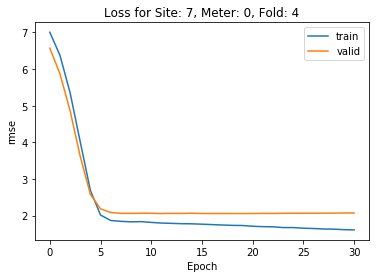

CPU times: user 6.02 s, sys: 355 ms, total: 6.37 s
Wall time: 4.96 s

CV RMSE for Site: 7 and Meter: 0 is 1.5567250008268696

CV RMSE for Site: 7 is 1.5567250008268696


In [11]:
for meter in df_train.meter.unique():
    print("Building Model for site_id", site_id, "and meter", meter)
        
    df_train_site_meter = df_train[df_train.meter == meter].reset_index(drop=True)
    df_test_site_meter = df_test[df_test.meter == meter].reset_index(drop=True)
    
    pred_val = np.zeros(df_train_site_meter.shape[0])
    pred_test = np.zeros(df_test_site_meter.shape[0])

    row_ids_test = df_test_site_meter.row_id
    y_train_site_meter = df_train_site_meter.log_meter_reading.values
    
    df_train_site_meter = df_train_site_meter[features]
    df_test_site_meter = df_test_site_meter[features]

    df_train_site_meter = pd.get_dummies(df_train_site_meter)
    df_test_site_meter = pd.get_dummies(df_test_site_meter)
        
    for k, (train_idx, valid_idx) in enumerate(folds.split(df_train_site_meter, y_train_site_meter)):
        print("Preparing Site:", site_id, ", meter:", meter, ", Fold:", k+1)
        
        X_train, y_train = df_train_site_meter.iloc[train_idx], y_train_site_meter[train_idx]
        X_valid, y_valid = df_train_site_meter.iloc[valid_idx], y_train_site_meter[valid_idx]
        
        X_train.dropna(axis=1, how="all", inplace=True)
        X_train = X_train.loc[:, (X_train != X_train.iloc[0]).any()]

        X_valid = X_valid[X_train.columns]
        X_test = df_test_site_meter[X_train.columns]
        
        df_means = pd.concat([X_train, X_valid, X_test], ignore_index=True).mean()
        X_train.fillna(df_means, inplace=True)
        X_valid.fillna(df_means, inplace=True)
        X_test.fillna(df_means, inplace=True)
        
        sc = MinMaxScaler()
        sc.fit(pd.concat([X_train, X_valid, X_test], ignore_index=True))
        
        X_train = np.array(sc.transform(X_train))
        X_valid = np.array(sc.transform(X_valid))
        X_test = np.array(sc.transform(X_test))
        
        model = Sequential()
        model.add(Dense(32, input_dim=X_train.shape[1], activation="relu", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(8, activation="tanh", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(4, activation="tanh", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss=rmse, optimizer="adam")
        
        model_ffnn = model.fit(X_train, y_train, epochs=31, batch_size=500, validation_data=(X_valid, y_valid), verbose=2, shuffle=False)

        plt.plot(model_ffnn.history["loss"])
        plt.plot(model_ffnn.history["val_loss"])
        plt.title("Loss for Site: " + str(site_id) + ", Meter: " + str(meter) + ", Fold: " + str(k+1))
        plt.ylabel("rmse")
        plt.xlabel("Epoch")
        plt.legend(["train", "valid"], loc="upper right")
        plt.show()
        
        pred_val[valid_idx] = model.predict(X_valid).ravel()
        %time pred_test += model.predict(X_test).ravel() / cv
        
        gc.collect()
        
    df_valid = pd.DataFrame({"site_id": site_id, "meter": meter, "meter_reading": np.expm1(y_train_site_meter), "pred_ffnn": np.clip(np.expm1(pred_val), 0, a_max=None)})
    df_pred = pd.DataFrame({"row_id": row_ids_test, "meter_reading": np.clip(np.expm1(pred_test), 0, a_max=None)})
    
    df_cv.append(df_valid)
    df_preds.append(df_pred)
    
    gc.collect()
    
    print("\nCV RMSE for Site:", site_id, "and Meter:", meter, "is", np.sqrt(mean_squared_error(np.log1p(df_valid.meter_reading), np.log1p(df_valid.pred_ffnn))))

df_cv = pd.concat(df_cv)
print("\nCV RMSE for Site:", site_id, "is", np.sqrt(mean_squared_error(np.log1p(df_cv.meter_reading), np.log1p(df_cv.pred_ffnn))))


In [12]:
df_preds = pd.concat(df_preds)
df_preds.to_csv("../sub/ffnn_pred_site_" + str(site_id) + ".csv", index=False)